### ICA-PCA Combined Approach to Denoising and Dimensionality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA, PCA

In [2]:
df = pd.read_csv('working_data.csv')

##### Splitting Data by Activity Type

In [4]:
def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')
other_df = activity_df('Other')

##### Functions to Scale, Perform ICA and PCA, and Plot Signals

In [5]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row: last_row]
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = electrodes)
    return sub_eeg

def activity_signal_plots(sub_eegs, activities, electrodes, h, w):
    fig, axs = plt.subplots(len(electrodes), len(sub_eegs))
    fig.set_figheight(h)
    fig.set_figwidth(w)
    fig.tight_layout()
    for i in range(len(electrodes)):
        if len(sub_eegs) == 1:
            axs[i].plot(sub_eegs[0][electrodes[i]])
            axs[i].set_title('{}_{}'.format(activities[0], electrodes[i]))
        else:
            for j in range(len(sub_eegs)):
                axs[i][j].plot(sub_eegs[j][electrodes[i]])
                if len(activities) > 1:
                    axs[i][j].set_title('{}_{}'.format(activities[j], electrodes[i]))
                else:
                    axs[i][j].set_title('{}_{}'.format(activities[0], electrodes[i]))
    plt.show()

def ica_function(sub_eeg, group):
    sub_eeg = sub_eeg[group]
    ica = FastICA(max_iter = 500, random_state = 32)
    sub_eeg = ica.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = ['component_{}'.format(i) for i in range(len(group))])
    return sub_eeg
    
def pca_function(sub_eeg, group, n):
    sub_eeg = sub_eeg[group]
    pca = PCA(n_components = n, random_state = 42)
    sub_eeg = pca.fit_transform(sub_eeg)
    ratio = pca.explained_variance_ratio_
    sub_eeg = pd.DataFrame(sub_eeg, columns = ['component_{}'.format(i) for i in range(n)])
    return sub_eeg, ratio

##### Left/Right Electrode Split

In [11]:
left = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz']
right = ['Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']

### Explained Variance Ratio to Evaluate PCA after ICA

In [6]:
seizure_indexes = [i for i in range(seizure_df.shape[0])]
other_indexes = [i for i in range(other_df.shape[0])]
gpd_indexes = [i for i in range(gpd_df.shape[0])]
grda_indexes = [i for i in range(grda_df.shape[0])]
lrda_indexes = [i for i in range(lrda_df.shape[0])]
lpd_indexes = [i for i in range(lpd_df.shape[0])]

In [7]:
df['expert_consensus'].value_counts(normalize = True)

expert_consensus
Seizure    0.209216
Other      0.189732
GPD        0.157017
GRDA       0.155822
LRDA       0.146853
LPD        0.141360
Name: proportion, dtype: float64

In [8]:
s_count_norm = df['expert_consensus'].value_counts(normalize = True)[0]
o_count_norm = df['expert_consensus'].value_counts(normalize = True)[1]
gpd_count_norm = df['expert_consensus'].value_counts(normalize = True)[2]
grda_count_norm = df['expert_consensus'].value_counts(normalize = True)[3]
lrda_count_norm = df['expert_consensus'].value_counts(normalize = True)[4]
lpd_count_norm = df['expert_consensus'].value_counts(normalize = True)[5]

norm_list = [s_count_norm, o_count_norm, gpd_count_norm, grda_count_norm,
             lrda_count_norm, lpd_count_norm]
activity_counts_1000 = []
for norm in norm_list:
    activity_count = norm * 1000
    activity_counts_1000.append(activity_count)
    
activity_counts_1000

[209.21557739201816,
 189.73176561481444,
 157.01731089596564,
 155.82220719959437,
 146.85289359955576,
 141.3602452980516]

In [9]:
seizure_norm1000 = np.random.choice(seizure_indexes, size = 209, replace = False)
other_norm1000 = np.random.choice(other_indexes, size = 190, replace = False)
gpd_norm1000 = np.random.choice(gpd_indexes, size = 157, replace = False)
grda_norm1000 = np.random.choice(grda_indexes, size = 156, replace = False)
lrda_norm1000 = np.random.choice(lrda_indexes, size = 147, replace = False)
lpd_norm1000 = np.random.choice(lpd_indexes, size = 141, replace = False)

evr2 = []
evr3 = []
evr4 = []

In [12]:
for i in seizure_norm1000:
    seizure_eeg = scale(seizure_df, i)
    seizure_left = ica_function(seizure_eeg, left)
    seizure_right = ica_function(seizure_eeg, right)
    cols = seizure_left.columns
    
    seizure_l2components, seizure_evrl2 = pca_function(seizure_left, cols, 2)
    seizure_r2components, seizure_evrr2 = pca_function(seizure_right, cols, 2)
    evr2.append(seizure_evrl2.sum())
    evr2.append(seizure_evrr2.sum())
    
    seizure_l3components, seizure_evrl3 = pca_function(seizure_left, cols, 3)
    seizure_r3components, seizure_evrr3 = pca_function(seizure_right, cols, 3)
    evr3.append(seizure_evrl3.sum())
    evr3.append(seizure_evrr3.sum())
    
    seizure_l4components, seizure_evrl4 = pca_function(seizure_left, cols, 4)
    seizure_r4components, seizure_evrr4 = pca_function(seizure_right, cols, 4)
    evr4.append(seizure_evrl4.sum())
    evr4.append(seizure_evrr4.sum())

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

In [13]:
for i in lpd_norm1000:
    lpd_eeg = scale(lpd_df, i)
    lpd_left = ica_function(lpd_eeg, left)
    lpd_right = ica_function(lpd_eeg, right)
    cols = lpd_left.columns
    
    lpd_l2components, lpd_evrl2 = pca_function(lpd_left, cols, 2)
    lpd_r2components, lpd_evrr2 = pca_function(lpd_right, cols, 2)
    evr2.append(lpd_evrl2.sum())
    evr2.append(lpd_evrr2.sum())
    
    lpd_l3components, lpd_evrl3 = pca_function(lpd_left, cols, 3)
    lpd_r3components, lpd_evrr3 = pca_function(lpd_right, cols, 3)
    evr3.append(lpd_evrl3.sum())
    evr3.append(lpd_evrr3.sum())
    
    lpd_l4components, lpd_evrl4 = pca_function(lpd_left, cols, 4)
    lpd_r4components, lpd_evrr4 = pca_function(lpd_right, cols, 4)
    evr4.append(lpd_evrl4.sum())
    evr4.append(lpd_evrr4.sum())

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

In [14]:
for i in gpd_norm1000:
    gpd_eeg = scale(gpd_df, i)
    gpd_left = ica_function(gpd_eeg, left)
    gpd_right = ica_function(gpd_eeg, right)
    cols = gpd_left.columns
    
    gpd_l2components, gpd_evrl2 = pca_function(gpd_left, cols, 2)
    gpd_r2components, gpd_evrr2 = pca_function(gpd_right, cols, 2)
    evr2.append(gpd_evrl2.sum())
    evr2.append(gpd_evrr2.sum())
    
    gpd_l3components, gpd_evrl3 = pca_function(gpd_left, cols, 3)
    gpd_r3components, gpd_evrr3 = pca_function(gpd_right, cols, 3)
    evr3.append(gpd_evrl3.sum())
    evr3.append(gpd_evrr3.sum())
    
    gpd_l4components, gpd_evrl4 = pca_function(gpd_left, cols, 4)
    gpd_r4components, gpd_evrr4 = pca_function(gpd_right, cols, 4)
    evr4.append(gpd_evrl4.sum())
    evr4.append(gpd_evrr4.sum())

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

In [15]:
for i in lrda_norm1000:
    lrda_eeg = scale(lrda_df, i)
    lrda_left = ica_function(lrda_eeg, left)
    lrda_right = ica_function(lrda_eeg, right)
    cols = lrda_left.columns
    
    lrda_l2components, lrda_evrl2 = pca_function(lrda_left, cols, 2)
    lrda_r2components, lrda_evrr2 = pca_function(lrda_right, cols, 2)
    evr2.append(lrda_evrl2.sum())
    evr2.append(lrda_evrr2.sum())
    
    lrda_l3components, lrda_evrl3 = pca_function(lrda_left, cols, 3)
    lrda_r3components, lrda_evrr3 = pca_function(lrda_right, cols, 3)
    evr3.append(lrda_evrl3.sum())
    evr3.append(lrda_evrr3.sum())
    
    lrda_l4components, lrda_evrl4 = pca_function(lrda_left, cols, 4)
    lrda_r4components, lrda_evrr4 = pca_function(lrda_right, cols, 4)
    evr4.append(lrda_evrl4.sum())
    evr4.append(lrda_evrr4.sum())

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

In [16]:
for i in grda_norm1000:
    grda_eeg = scale(grda_df, i)
    grda_left = ica_function(grda_eeg, left)
    grda_right = ica_function(grda_eeg, right)
    cols = grda_left.columns
    
    grda_l2components, grda_evrl2 = pca_function(grda_left, cols, 2)
    grda_r2components, grda_evrr2 = pca_function(grda_right, cols, 2)
    evr2.append(grda_evrl2.sum())
    evr2.append(grda_evrr2.sum())
    
    grda_l3components, grda_evrl3 = pca_function(grda_left, cols, 3)
    grda_r3components, grda_evrr3 = pca_function(grda_right, cols, 3)
    evr3.append(grda_evrl3.sum())
    evr3.append(grda_evrr3.sum())
    
    grda_l4components, grda_evrl4 = pca_function(grda_left, cols, 4)
    grda_r4components, grda_evrr4 = pca_function(grda_right, cols, 4)
    evr4.append(grda_evrl4.sum())
    evr4.append(grda_evrr4.sum())

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

In [17]:
for i in other_norm1000:
    other_eeg = scale(other_df, i)
    other_left = ica_function(other_eeg, left)
    other_right = ica_function(other_eeg, right)
    cols = other_left.columns
    
    other_l2components, other_evrl2 = pca_function(other_left, cols, 2)
    other_r2components, other_evrr2 = pca_function(other_right, cols, 2)
    evr2.append(other_evrl2.sum())
    evr2.append(other_evrr2.sum())
    
    other_l3components, other_evrl3 = pca_function(other_left, cols, 3)
    other_r3components, other_evrr3 = pca_function(other_right, cols, 3)
    evr3.append(other_evrl3.sum())
    evr3.append(other_evrr3.sum())
    
    other_l4components, other_evrl4 = pca_function(other_left, cols, 4)
    other_r4components, other_evrr4 = pca_function(other_right, cols, 4)
    evr4.append(other_evrl4.sum())
    evr4.append(other_evrr4.sum())

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider 

In [18]:
evr2_left, evr2_right = [], []
evr3_left, evr3_right = [], []
evr4_left, evr4_right = [], []

for i in range(2000):
    if (i + 1) % 2 == 0:
        evr2_right.append(evr2[i])
        evr3_right.append(evr3[i])
        evr4_right.append(evr4[i])
    else:
        evr2_left.append(evr2[i])
        evr3_left.append(evr3[i])
        evr4_left.append(evr4[i])

In [19]:
print('Variance Explained N = 2 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr2)),
                                                             np.median(np.asarray(evr2))))
print('Variance Explained N = 3 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr3)),
                                                             np.median(np.asarray(evr3))))
print('Variance Explained N = 4 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr4)),
                                                             np.median(np.asarray(evr4))))

Variance Explained N = 2 Mean: 0.1818190969468443, Median: 0.1818185936460371
Variance Explained N = 3 Mean: 0.2727283064210779, Median: 0.2727277855189667
Variance Explained N = 4 Mean: 0.3636374663324582, Median: 0.36363693859367163


In [20]:
print('Left Variance Explained N = 2 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr2_left)),
                                                                  np.median(np.asarray(evr2_left))))
print('Right Variance Explained N = 2 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr2_right)),
                                                                  np.median(np.asarray(evr2_right))))

Left Variance Explained N = 2 Mean: 0.18181910644365096, Median: 0.18181860179724157
Right Variance Explained N = 2 Mean: 0.1818190874500376, Median: 0.18181858719552146


In [21]:
print('Left Variance Explained N = 3 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr3_left)),
                                                                  np.median(np.asarray(evr3_left))))
print('Right Variance Explained N = 3 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr3_right)),
                                                                  np.median(np.asarray(evr3_right))))

Left Variance Explained N = 3 Mean: 0.27272832117731505, Median: 0.27272779297020905
Right Variance Explained N = 3 Mean: 0.27272829166484086, Median: 0.27272777712343554


In [22]:
print('Left Variance Explained N = 4 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr4_left)),
                                                                  np.median(np.asarray(evr4_left))))
print('Right Variance Explained N = 4 Mean: {}, Median: {}'.format(np.mean(np.asarray(evr4_right)),
                                                                  np.median(np.asarray(evr4_right))))

Left Variance Explained N = 4 Mean: 0.36363748306285365, Median: 0.36363694832734195
Right Variance Explained N = 4 Mean: 0.3636374496020626, Median: 0.36363693209106984


### First Attempts with Left/Right Electrode Split

In [22]:
left = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz']
right = ['Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']

##### Seizure

In [23]:
seizure_indexes = [i for i in range(seizure_df.shape[0])]
seizure_randoms = np.random.choice(seizure_indexes, size = 3, replace = False)

seizure1 = scale(seizure_df, seizure_randoms[0])
seizure2 = scale(seizure_df, seizure_randoms[1])
seizure3 = scale(seizure_df, seizure_randoms[2])

In [24]:
seizure_left_ica1 = ica_function(seizure1, left)
seizure_right_ica1 = ica_function(seizure1, right)
seizure_left_ica2 = ica_function(seizure2, left)
seizure_right_ica2 = ica_function(seizure2, right)
seizure_left_ica3 = ica_function(seizure3, left)
seizure_right_ica3 = ica_function(seizure3, right)

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [34]:
sub_eeg_list = [seizure_left_ica1[0:400], seizure_right_ica1[0:400],
                seizure_left_ica2[0:400], seizure_right_ica2[0:400],
                seizure_left_ica3[0:400], seizure_right_ica3[0:400]]
names = ['Left_ICA1', 'Right_ICA1', 'Left_ICA2', 'Right_ICA2', 'Left_ICA3', 'Right_ICA3']
components = seizure_left_ica1.columns

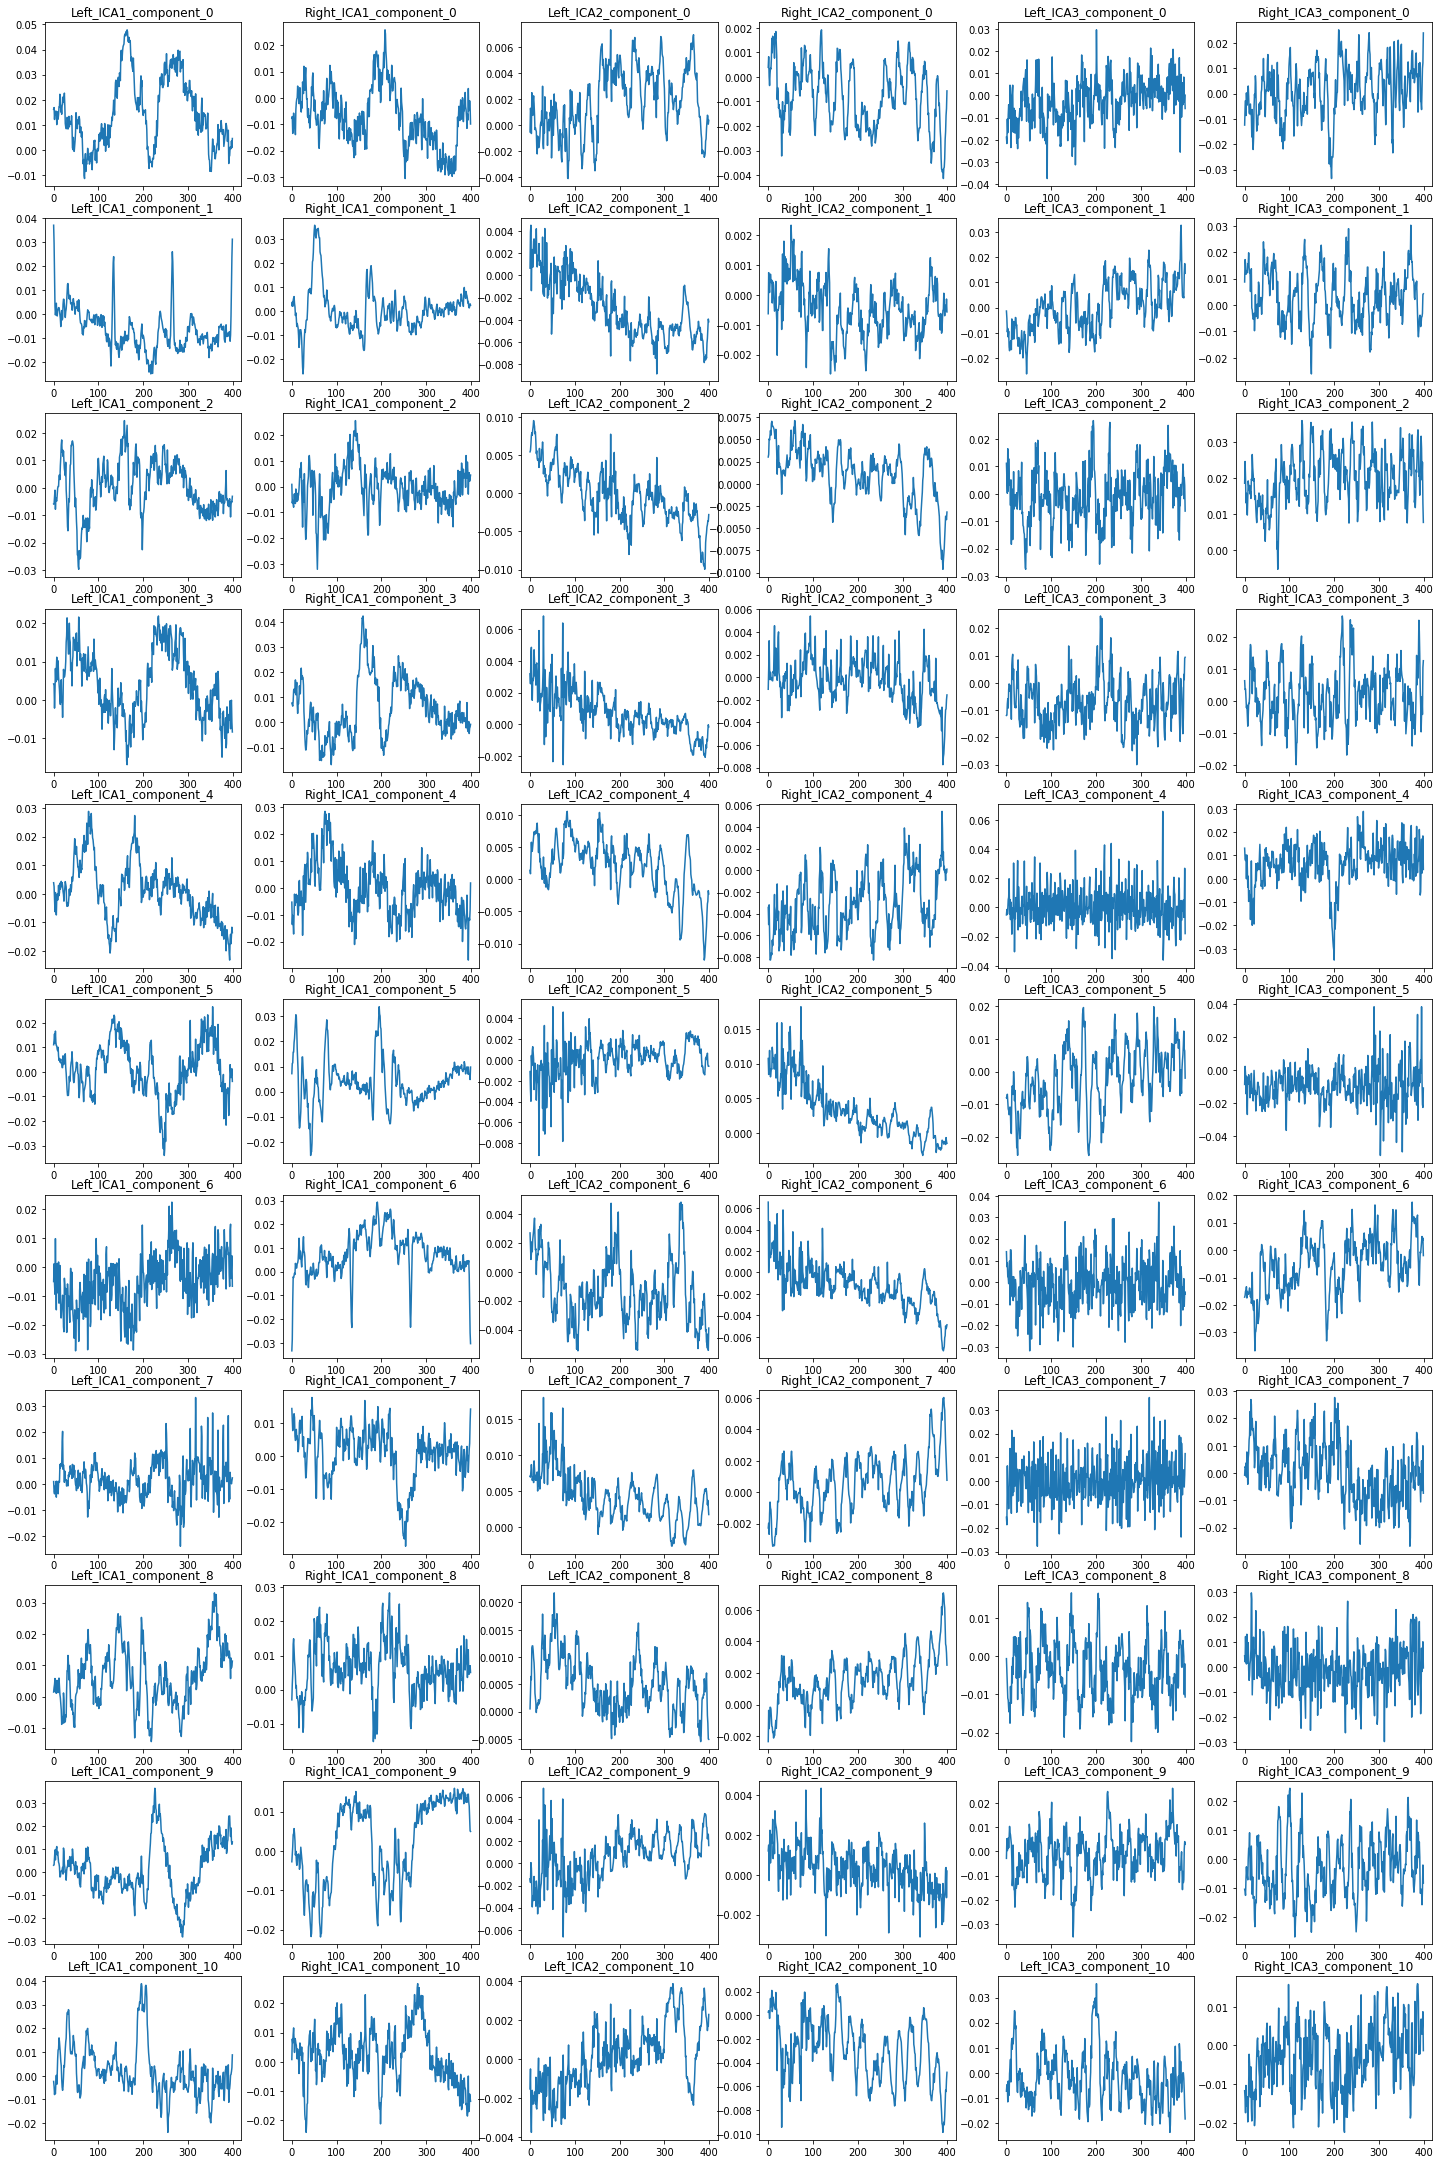

In [36]:
activity_signal_plots(sub_eeg_list, names, components, 30, 20)

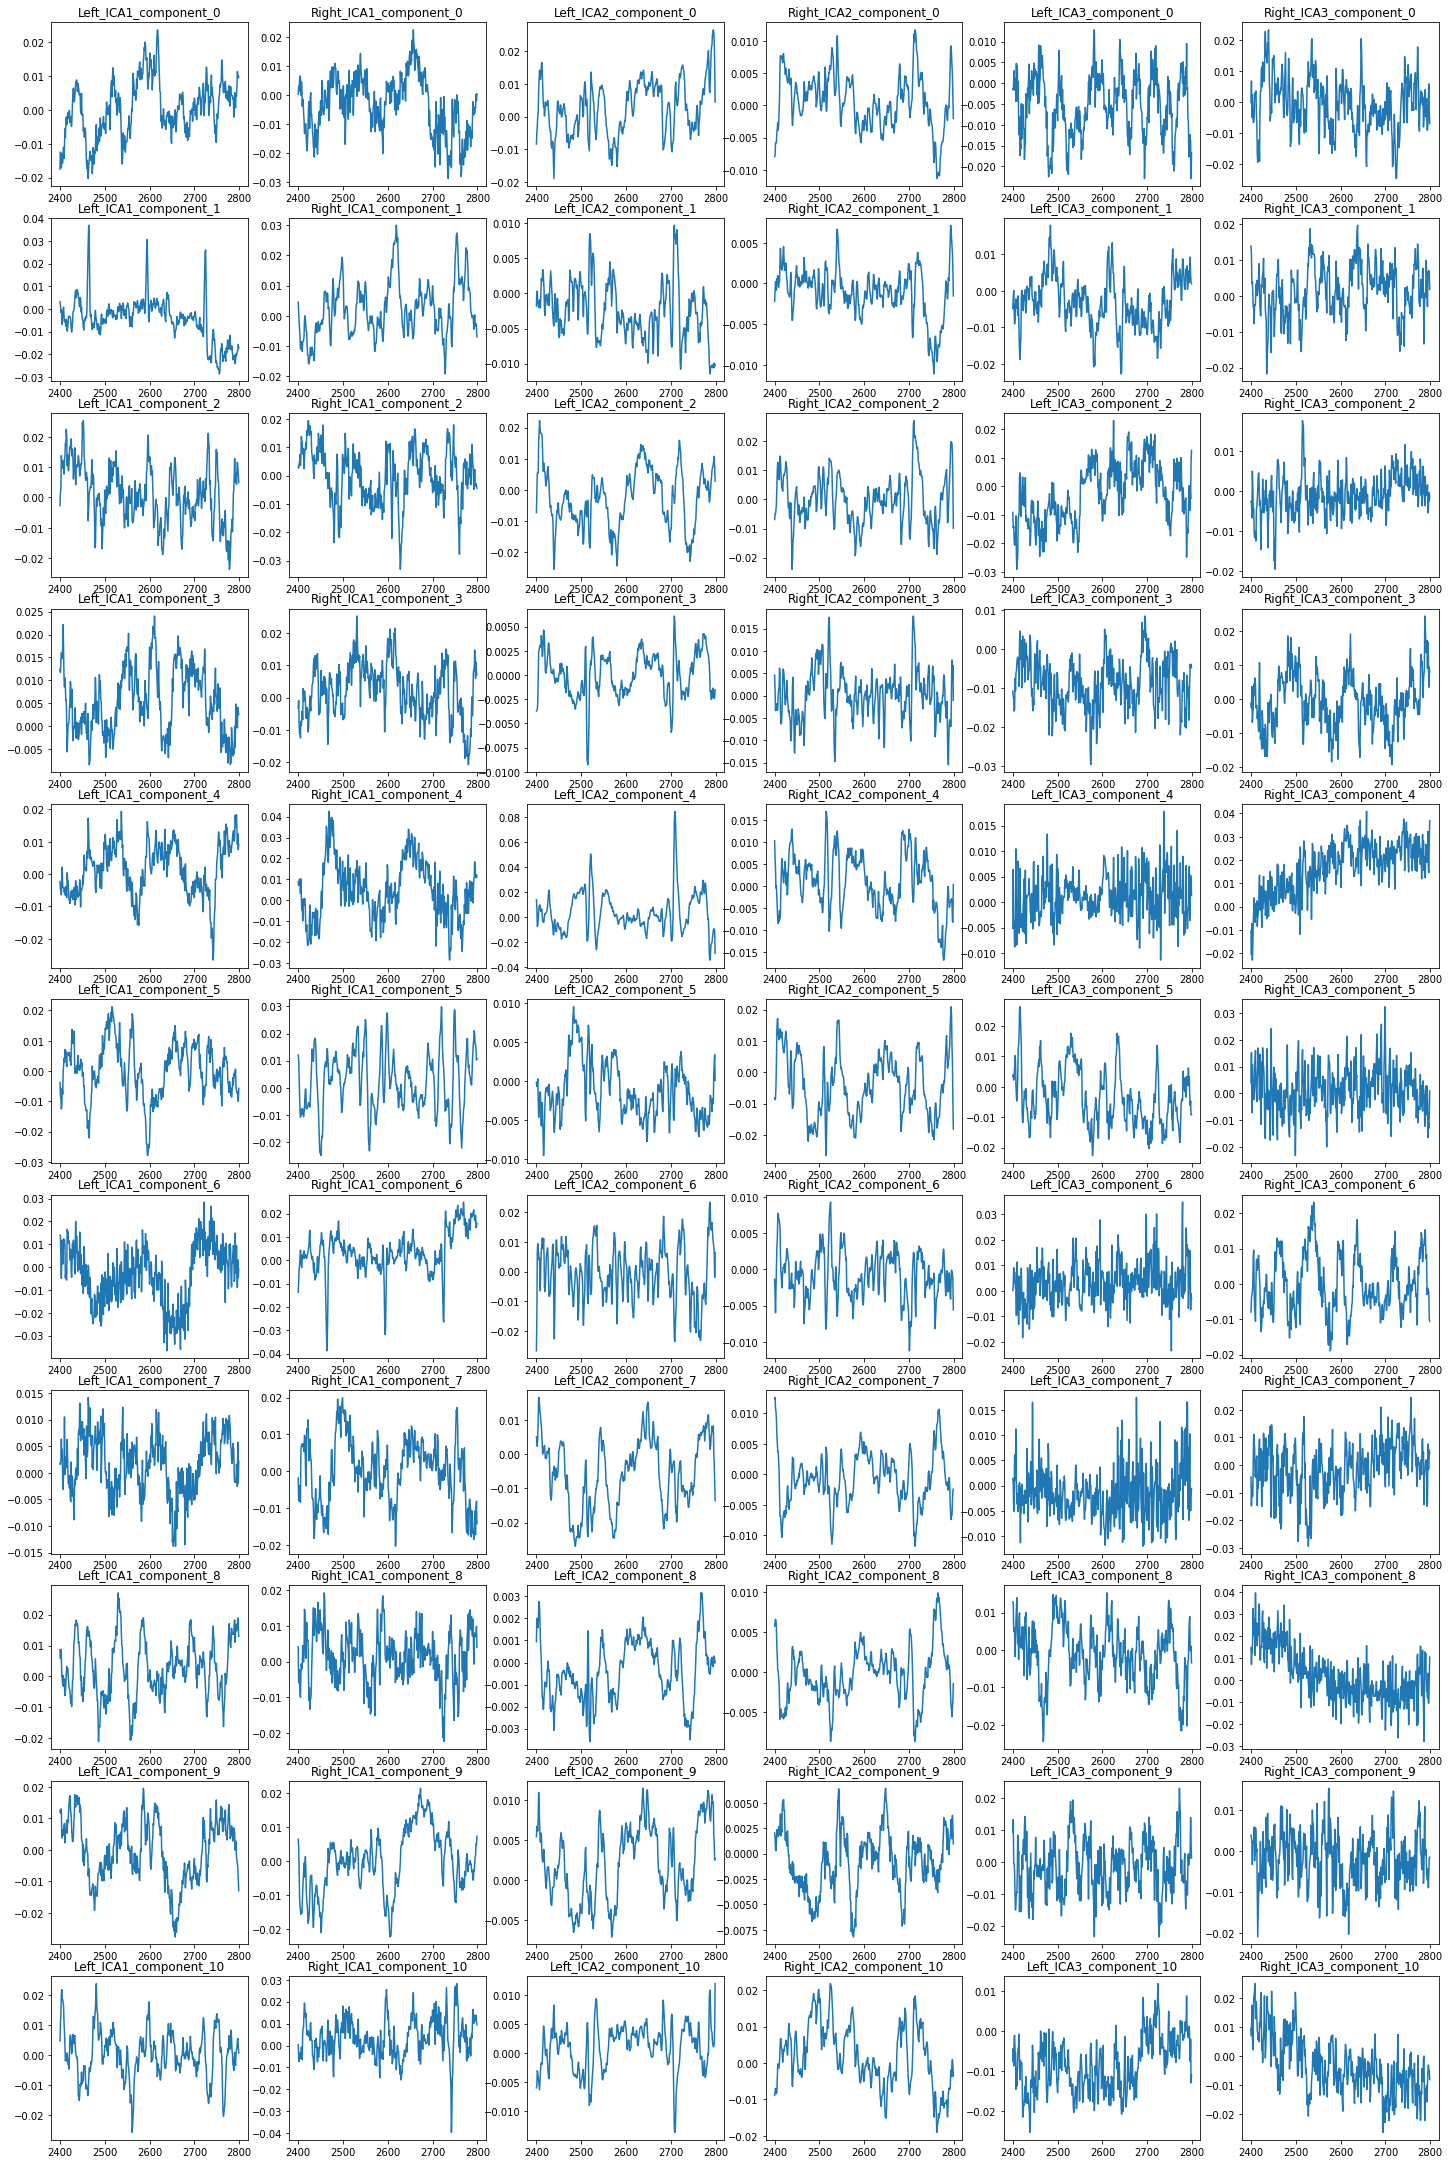

In [38]:
sub_eeg_list = [seizure_left_ica1[2400:2800], seizure_right_ica1[2400:2800],
                seizure_left_ica2[2400:2800], seizure_right_ica2[2400:2800],
                seizure_left_ica3[2400:2800], seizure_right_ica3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 30, 20)

In [43]:
cols = seizure_left_ica1.columns

In [44]:
seizure_left_pca1, seizure_left_ratio1 = pca_function(seizure_left_ica1, cols, 3)
seizure_right_pca1, seizure_right_ratio1 = pca_function(seizure_right_ica1, cols, 3)
seizure_left_pca2, seizure_left_ratio2 = pca_function(seizure_left_ica2, cols, 3)
seizure_right_pca2, seizure_right_ratio2 = pca_function(seizure_right_ica2, cols, 3)
seizure_left_pca3, seizure_left_ratio3 = pca_function(seizure_left_ica3, cols, 3)
seizure_right_pca3, seizure_right_ratio3 = pca_function(seizure_right_ica3, cols, 3)

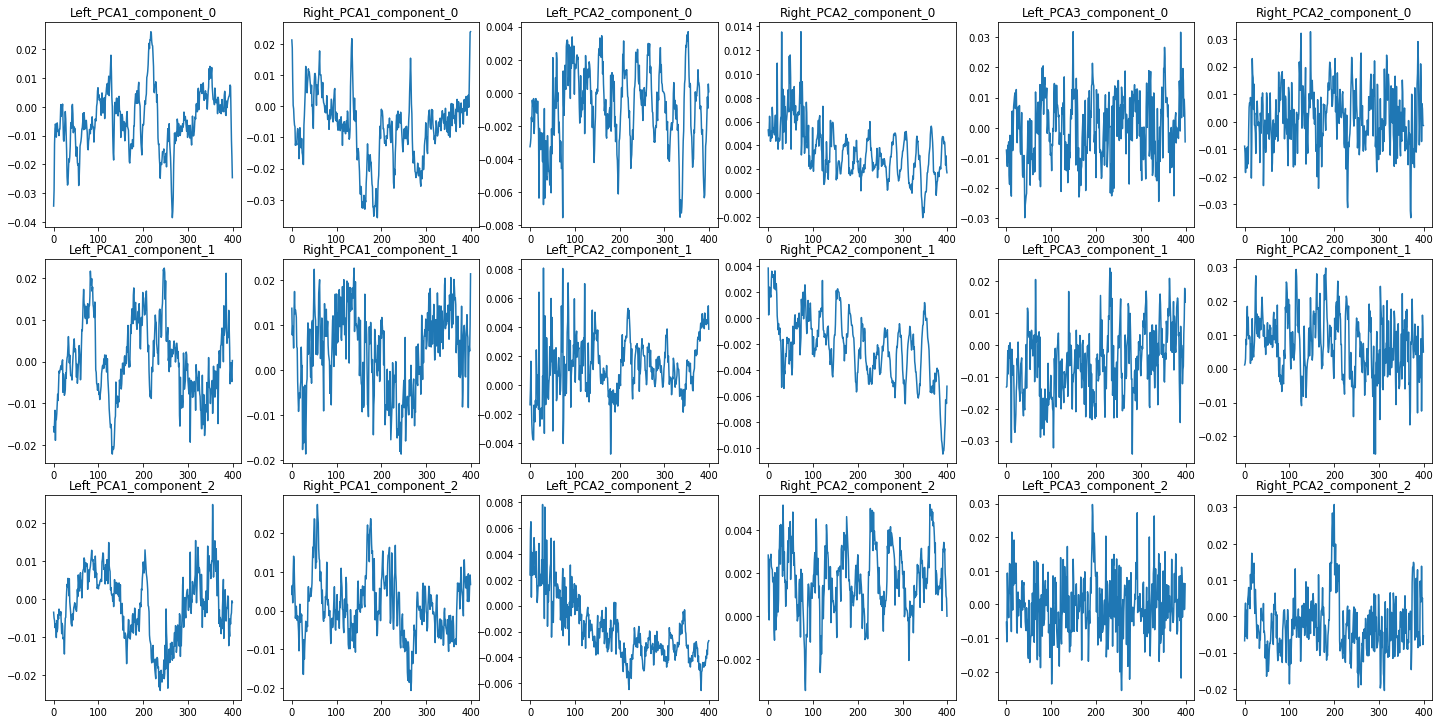

In [45]:
sub_eeg_list = [seizure_left_pca1[0:400], seizure_right_pca1[0:400],
                seizure_left_pca2[0:400], seizure_right_pca2[0:400],
                seizure_left_pca3[0:400], seizure_right_pca3[0:400]]
names = ['Left_PCA1', 'Right_PCA1', 'Left_PCA2', 'Right_PCA2', 'Left_PCA3', 'Right_PCA2']
components = seizure_left_pca1.columns
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

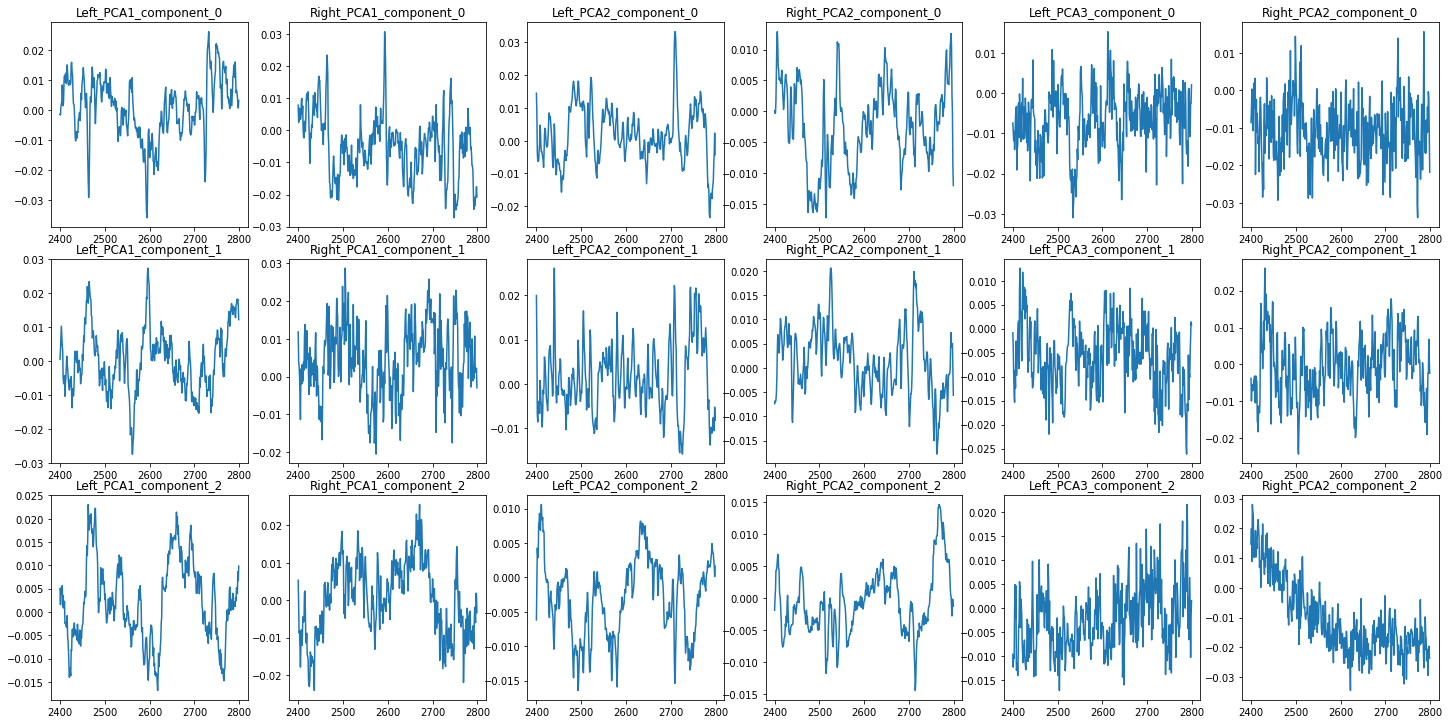

In [46]:
sub_eeg_list = [seizure_left_pca1[2400:2800], seizure_right_pca1[2400:2800],
                seizure_left_pca2[2400:2800], seizure_right_pca2[2400:2800],
                seizure_left_pca3[2400:2800], seizure_right_pca3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

##### LPD

In [47]:
lpd_indexes = [i for i in range(lpd_df.shape[0])]
lpd_randoms = np.random.choice(lpd_indexes, size = 3, replace = False)

lpd1 = scale(lpd_df, lpd_randoms[0])
lpd2 = scale(lpd_df, lpd_randoms[1])
lpd3 = scale(lpd_df, lpd_randoms[2])

In [48]:
lpd_left_ica1 = ica_function(lpd1, left)
lpd_right_ica1 = ica_function(lpd1, right)
lpd_left_ica2 = ica_function(lpd2, left)
lpd_right_ica2 = ica_function(lpd2, right)
lpd_left_ica3 = ica_function(lpd3, left)
lpd_right_ica3 = ica_function(lpd3, right)

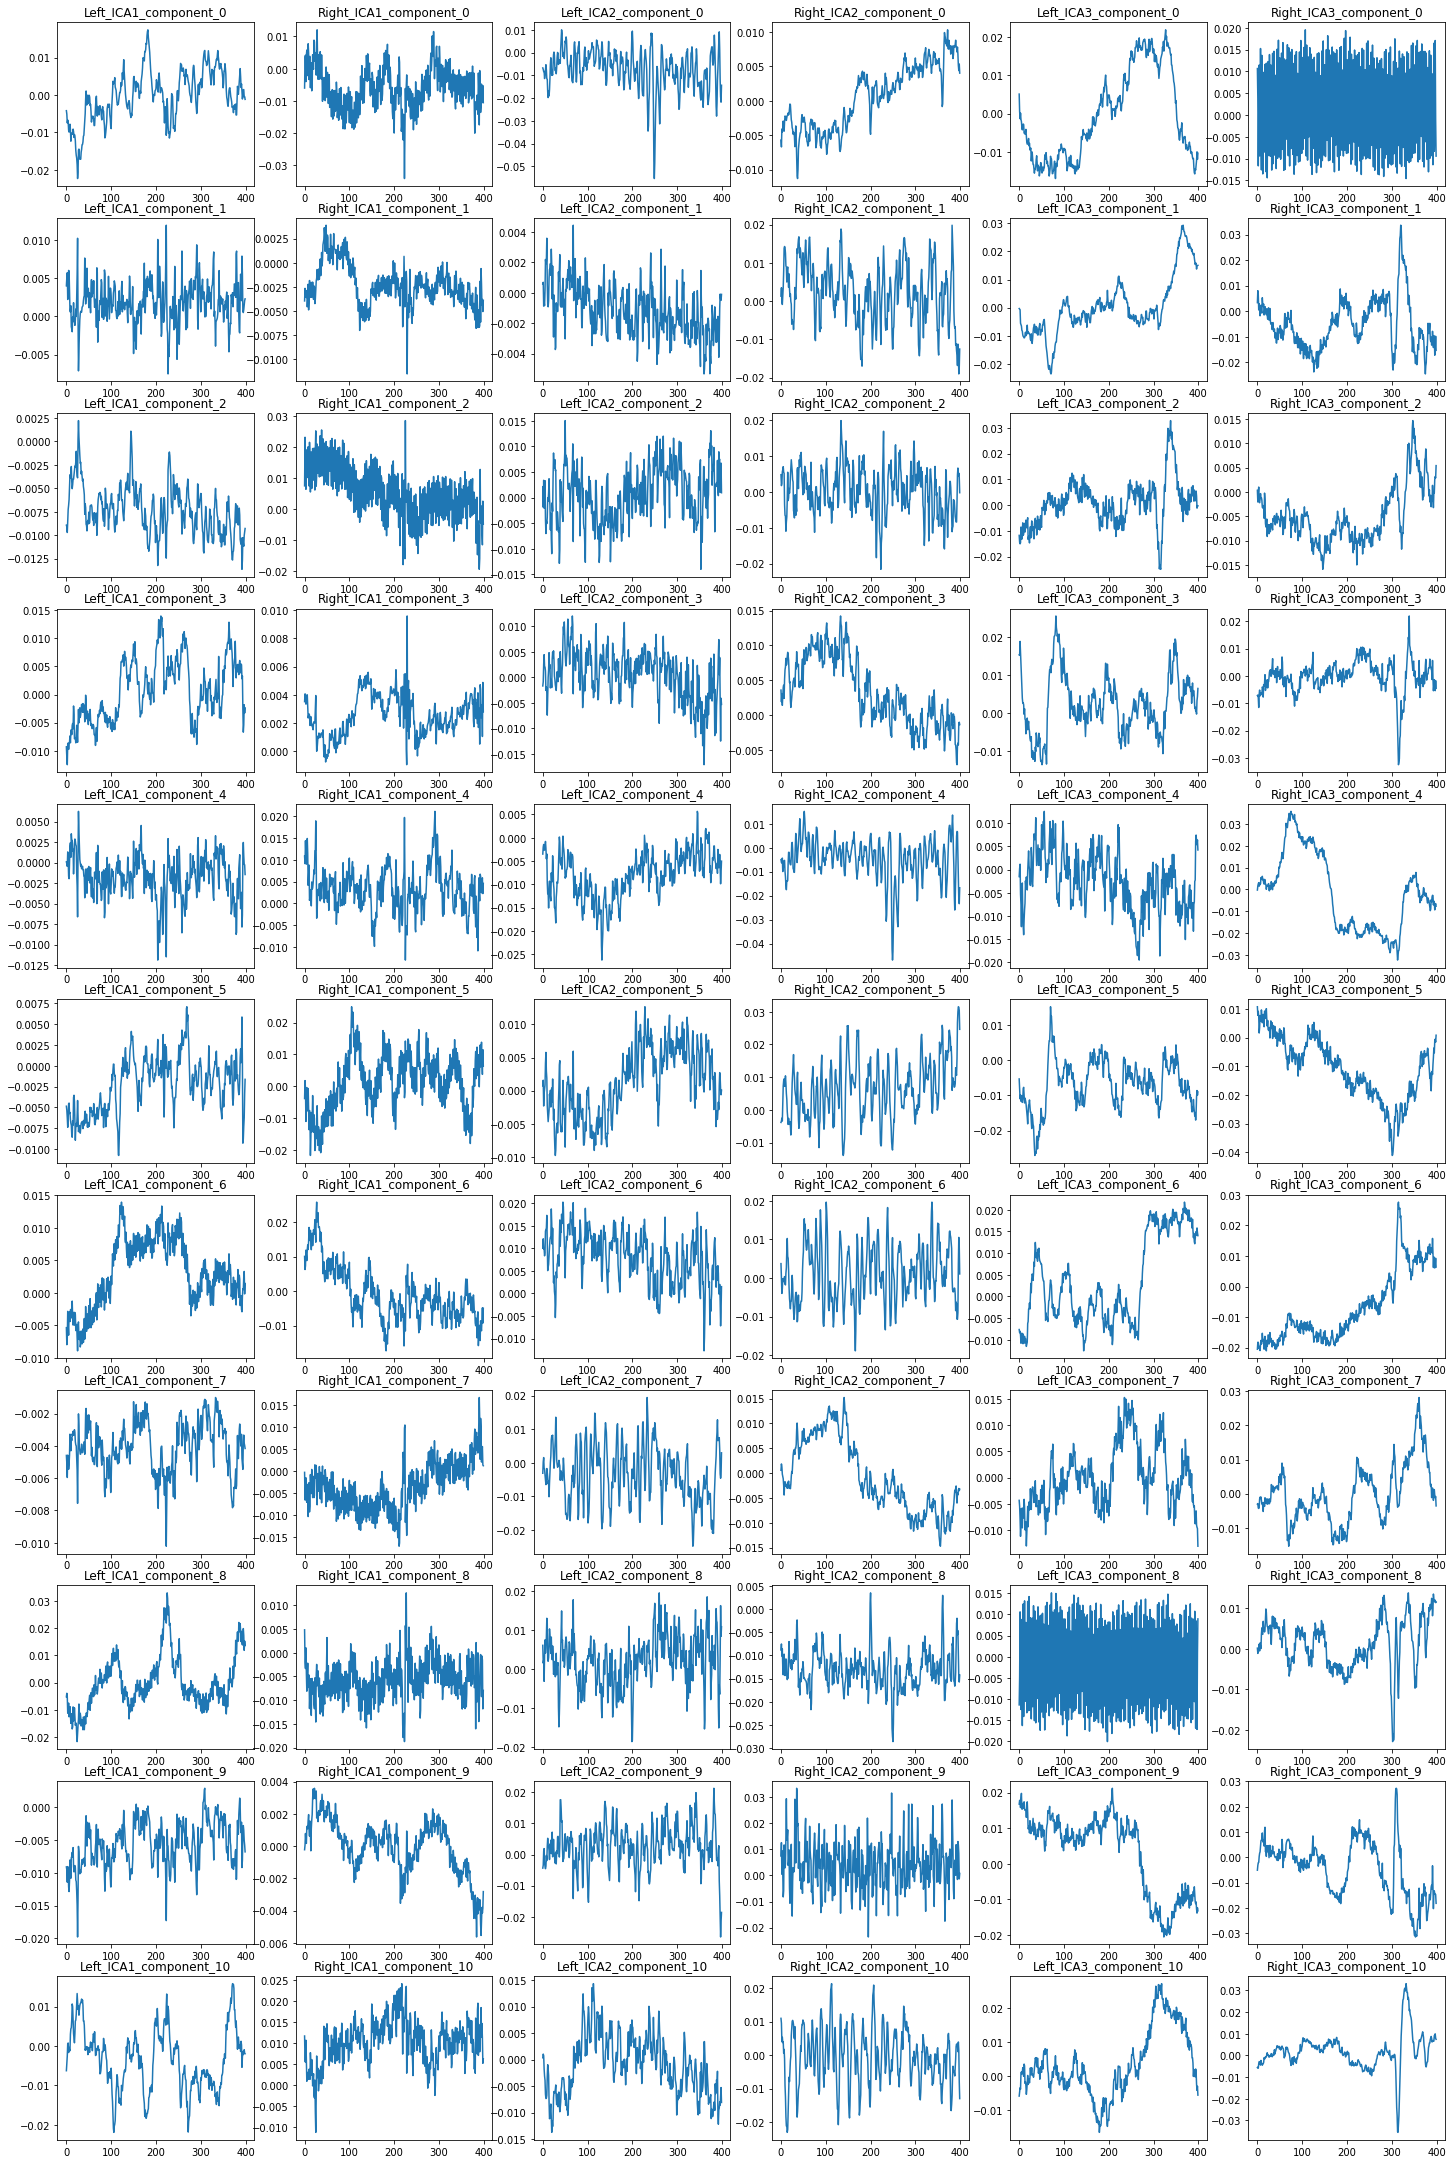

In [49]:
sub_eeg_list = [lpd_left_ica1[0:400], lpd_right_ica1[0:400],
                lpd_left_ica2[0:400], lpd_right_ica2[0:400],
                lpd_left_ica3[0:400], lpd_right_ica3[0:400]]
names = ['Left_ICA1', 'Right_ICA1', 'Left_ICA2', 'Right_ICA2', 'Left_ICA3', 'Right_ICA3']
components = lpd_left_ica1.columns
activity_signal_plots(sub_eeg_list, names, components, 30, 20)

In [50]:
cols = lpd_left_ica1.columns

lpd_left_pca1, lpd_left_ratio1 = pca_function(lpd_left_ica1, cols, 3)
lpd_right_pca1, lpd_right_ratio1 = pca_function(lpd_right_ica1, cols, 3)
lpd_left_pca2, lpd_left_ratio2 = pca_function(lpd_left_ica2, cols, 3)
lpd_right_pca2, lpd_right_ratio2 = pca_function(lpd_right_ica2, cols, 3)
lpd_left_pca3, lpd_left_ratio3 = pca_function(lpd_left_ica3, cols, 3)
lpd_right_pca3, lpd_right_ratio3 = pca_function(lpd_right_ica3, cols, 3)

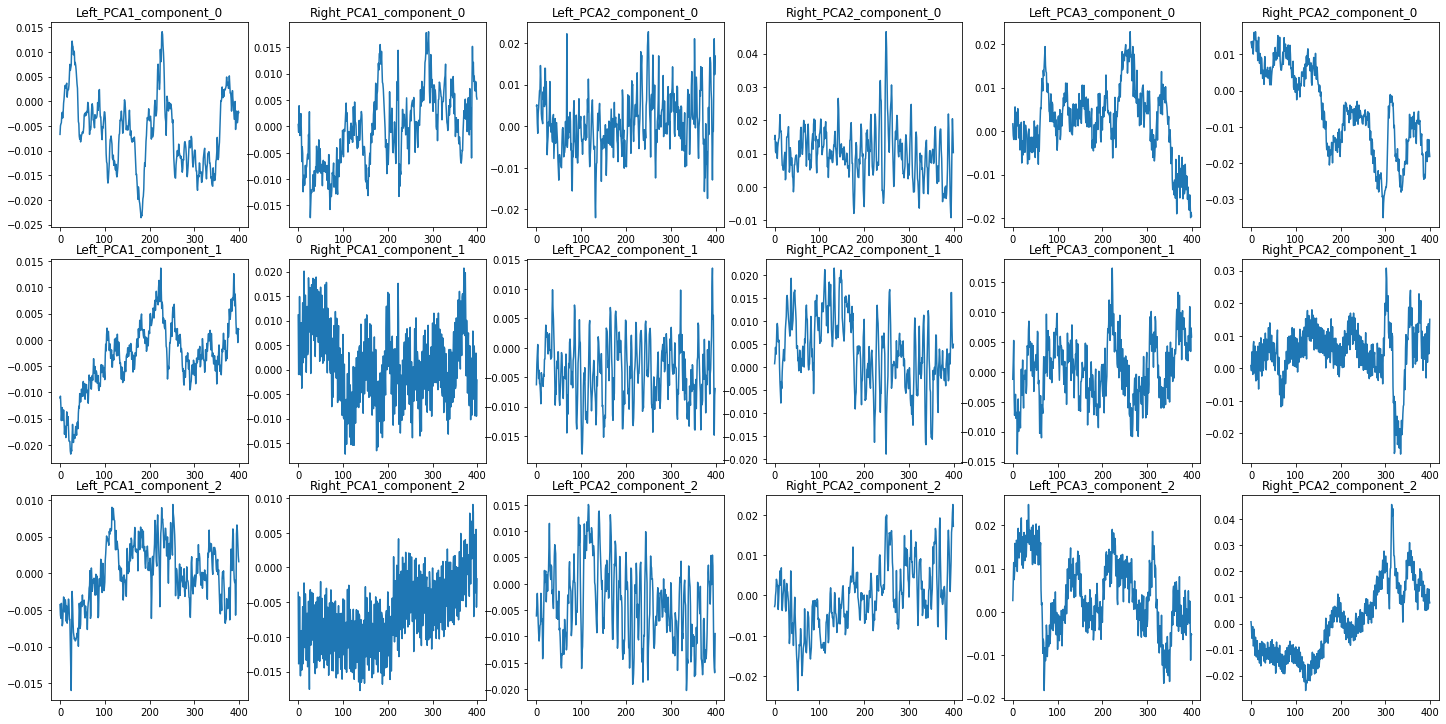

In [51]:
sub_eeg_list = [lpd_left_pca1[0:400], lpd_right_pca1[0:400],
                lpd_left_pca2[0:400], lpd_right_pca2[0:400],
                lpd_left_pca3[0:400], lpd_right_pca3[0:400]]
names = ['Left_PCA1', 'Right_PCA1', 'Left_PCA2', 'Right_PCA2', 'Left_PCA3', 'Right_PCA2']
components = lpd_left_pca1.columns
activity_signal_plots(sub_eeg_list, names, components, 10, 20)

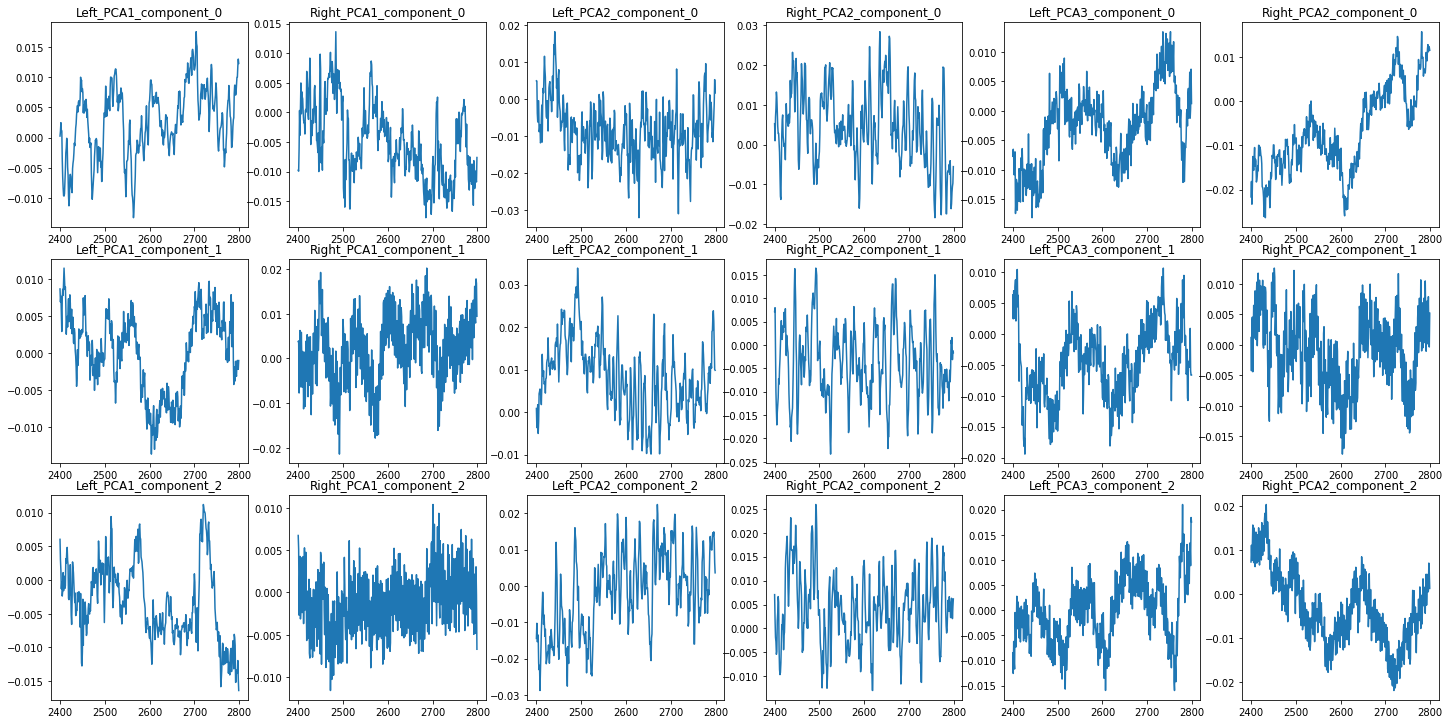

In [52]:
sub_eeg_list = [lpd_left_pca1[2400:2800], lpd_right_pca1[2400:2800],
                lpd_left_pca2[2400:2800], lpd_right_pca2[2400:2800],
                lpd_left_pca3[2400:2800], lpd_right_pca3[2400:2800]]
activity_signal_plots(sub_eeg_list, names, components, 10, 20)